In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
#Lectura de datos 
data = pd.read_csv('DEPURACION_FINAL.csv', sep=',')
data

,AÑO,MES,DIA,FECHA,HORA,KW-H
0,2015,1,jueves,1,0,3200
1,2015,1,jueves,1,1,3200
2,2015,1,jueves,1,2,2400
3,2015,1,jueves,1,3,2400
4,2015,1,jueves,1,4,2400
...,...,...,...,...,...,...
43819,2019,12,martes,31,19,3400
43820,2019,12,martes,31,20,3600
43821,2019,12,martes,31,21,3800
43822,2019,12,martes,31,22,4000


In [3]:
#Verificacion de nans 
data.isnull().values.any()
data.isnull().sum().sum()

data.isnull().sum()

AÑO      0
MES      0
DIA      0
FECHA    0
HORA     0
KW-H     0
dtype: int64

In [4]:
#Variable categrica DIA a numérica
data['DIA'] = data['DIA'].map({'lunes': 1 ,
                                           'martes': 2,
                                           'miercoles': 3,
                                           'miércoles': 3,
                                           'jueves': 4 , 
                                           'viernes': 5, 
                                           'sábado': 6,
                                           'sabado': 6,  #inconsistencia en la data por las tildes
                                           'domingo': 7})

data.head(50)


,AÑO,MES,DIA,FECHA,HORA,KW-H
0,2015,1,4,1,0,3200
1,2015,1,4,1,1,3200
2,2015,1,4,1,2,2400
3,2015,1,4,1,3,2400
4,2015,1,4,1,4,2400
5,2015,1,4,1,5,2400
6,2015,1,4,1,6,2400
7,2015,1,4,1,7,2400
8,2015,1,4,1,8,2400
9,2015,1,4,1,9,2600


In [5]:
#Transformacion de datos a numerica

data['KW-H'] = [valor.replace(",", ".") for valor in data['KW-H'] ]
data['KW-H'] = [float(valor) for valor in data['KW-H'] ]
data.iloc[26306, :]


AÑO      2018.0
MES         1.0
DIA         1.0
FECHA       1.0
HORA        2.0
KW-H        4.1
Name: 26306, dtype: float64

In [6]:
#Dividir los datos de entrenamiento y de test, 80/20
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 30)


In [7]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(data.isnull().sum())

(35059, 5)
(8765, 5)
(35059,)
(8765,)
AÑO      0
MES      0
DIA      0
FECHA    0
HORA     0
KW-H     0
dtype: int64


In [8]:
#Escalamiento de datso con StandardScaler
#En vista de loss nan 
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)
x_train


array([[ 7.04547816e-01, -7.30349773e-01,  4.98924639e-01,
        -3.14982389e-01,  1.22628325e+00],
       [ 7.04547816e-01,  1.30168126e+00, -7.11651507e-05,
        -1.67780697e+00, -5.06949654e-01],
       [-2.46028089e-03, -4.40059626e-01, -9.98062773e-01,
        -1.56423825e+00,  2.15230722e-01],
       ...,
       [ 7.04547816e-01,  1.01139111e+00, -7.11651507e-05,
         2.52861186e-01, -1.08469395e+00],
       [-1.41647648e+00,  1.40520668e-01, -4.99066969e-01,
        -8.82825964e-01, -9.40257879e-01],
       [ 1.41155591e+00, -1.49769479e-01,  9.97920443e-01,
        -1.67780697e+00, -9.40257879e-01]])

In [20]:
#Crear el modelo 
model = Sequential()
#Capa de entrada y primera capa oculta
model.add(Dense(1024, input_dim = 5, activation= "relu"))
# model.add(Dense(1))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

# sgd = SGD(lr=0.01, nesterov=True); NAN
model.compile(optimizer = 'adam', loss = "mean_squared_error")

In [21]:
#Entrenar con el algoritmo de back indicado 
model.fit(x_train, y_train, epochs = 100 , batch_size= 32)


#Ver el error 

Epoch 1/100
35059/35059 [==============================] - 18s 502us/step - loss: 1769365.4137
Epoch 2/100
35059/35059 [==============================] - 18s 522us/step - loss: 1428633.6646
Epoch 3/100
35059/35059 [==============================] - 19s 529us/step - loss: 1402395.3742
Epoch 4/100
35059/35059 [==============================] - 18s 521us/step - loss: 1276532.7661
Epoch 5/100
35059/35059 [==============================] - 18s 502us/step - loss: 1129348.7666
Epoch 6/100
35059/35059 [==============================] - 18s 499us/step - loss: 964557.4403
Epoch 7/100
35059/35059 [==============================] - 17s 494us/step - loss: 894137.0098
Epoch 8/100
35059/35059 [==============================] - 17s 498us/step - loss: 853342.6636
Epoch 9/100
35059/35059 [==============================] - 18s 499us/step - loss: 828502.7363
Epoch 10/100
35059/35059 [==============================] - 17s 494us/step - loss: 795511.3121
Epoch 11/100
35059/35059 [============================

35059/35059 [==============================] - 16s 468us/step - loss: 213522.7584
Epoch 88/100
35059/35059 [==============================] - 16s 468us/step - loss: 213368.9490
Epoch 89/100
35059/35059 [==============================] - 17s 477us/step - loss: 212038.1426
Epoch 90/100
35059/35059 [==============================] - 16s 459us/step - loss: 212820.2831
Epoch 91/100
35059/35059 [==============================] - 17s 472us/step - loss: 213645.4942
Epoch 92/100
35059/35059 [==============================] - 16s 468us/step - loss: 211144.5119
Epoch 93/100
35059/35059 [==============================] - 16s 469us/step - loss: 209776.6659
Epoch 94/100
35059/35059 [==============================] - 17s 479us/step - loss: 210344.8484
Epoch 95/100
35059/35059 [==============================] - 18s 503us/step - loss: 207651.1958
Epoch 96/100
35059/35059 [==============================] - 16s 463us/step - loss: 209348.4724
Epoch 97/100
35059/35059 [==============================] - 16s

In [23]:
#Crear el modelo 
model = Sequential()
#Capa de entrada y primera capa oculta
model.add(Dense(256, input_dim = 5, activation= "tanh"))
# model.add(Dense(1))
model.add(Activation('tanh'))
model.add(Dropout(0.1))

model.add(Dense(128))
model.add(Activation('tanh'))
model.add(Dropout(0.1))

model.add(Dense(1))

# sgd = SGD(lr=0.01, nesterov=True); NAN
model.compile(optimizer = 'adam', loss = "mean_squared_error")

#Entrenar con el algoritmo de back indicado 
model.fit(x_train, y_train, epochs = 100 , batch_size= 32)

Epoch 1/100
35059/35059 [==============================] - 7s 191us/step - loss: 9181317.8288
Epoch 2/100
35059/35059 [==============================] - 6s 179us/step - loss: 8404767.3721
Epoch 3/100
35059/35059 [==============================] - 7s 186us/step - loss: 7703320.4261
Epoch 4/100
35059/35059 [==============================] - 7s 187us/step - loss: 7048699.0470
Epoch 5/100
35059/35059 [==============================] - 6s 179us/step - loss: 6435609.2660
Epoch 6/100
35059/35059 [==============================] - 6s 180us/step - loss: 5860329.0794
Epoch 7/100
35059/35059 [==============================] - 6s 177us/step - loss: 5322739.3119
Epoch 8/100
35059/35059 [==============================] - 6s 184us/step - loss: 4822936.4599
Epoch 9/100
35059/35059 [==============================] - 7s 189us/step - loss: 4362577.3165
Epoch 10/100
35059/35059 [==============================] - 7s 189us/step - loss: 3935326.5667
Epoch 11/100
35059/35059 [==============================] -

35059/35059 [==============================] - 6s 180us/step - loss: 735974.9170
Epoch 88/100
35059/35059 [==============================] - 6s 180us/step - loss: 733649.0561
Epoch 89/100
35059/35059 [==============================] - 6s 182us/step - loss: 731977.3109
Epoch 90/100
35059/35059 [==============================] - 6s 183us/step - loss: 717276.1389
Epoch 91/100
35059/35059 [==============================] - 6s 179us/step - loss: 713480.9710
Epoch 92/100
35059/35059 [==============================] - 6s 179us/step - loss: 707976.5097
Epoch 93/100
35059/35059 [==============================] - 6s 180us/step - loss: 702129.0391
Epoch 94/100
35059/35059 [==============================] - 6s 181us/step - loss: 701170.5715
Epoch 95/100
35059/35059 [==============================] - 6s 179us/step - loss: 696190.0879
Epoch 96/100
35059/35059 [==============================] - 6s 180us/step - loss: 691739.4411
Epoch 97/100
35059/35059 [==============================] - 6s 184us/step

In [24]:
#Crear el modelo 
model = Sequential()
#Capa de entrada y primera capa oculta
model.add(Dense(256, input_dim = 5, activation= "relu"))
# model.add(Dense(1))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(1))

# sgd = SGD(lr=0.01, nesterov=True); NAN
model.compile(optimizer = 'adam', loss = "mean_squared_error")

#Entrenar con el algoritmo de back indicado 
model.fit(x_train, y_train, epochs = 100 , batch_size= 32)

Epoch 1/100
35059/35059 [==============================] - 6s 175us/step - loss: 2945286.0159
Epoch 2/100
35059/35059 [==============================] - 6s 170us/step - loss: 1464740.7538
Epoch 3/100
35059/35059 [==============================] - 6s 166us/step - loss: 1444007.8839
Epoch 4/100
35059/35059 [==============================] - 6s 166us/step - loss: 1426706.4507
Epoch 5/100
35059/35059 [==============================] - 6s 168us/step - loss: 1403211.7845
Epoch 6/100
35059/35059 [==============================] - 6s 165us/step - loss: 1362006.1355
Epoch 7/100
35059/35059 [==============================] - 6s 168us/step - loss: 1315987.1234
Epoch 8/100
35059/35059 [==============================] - 6s 168us/step - loss: 1263632.5573
Epoch 9/100
35059/35059 [==============================] - 6s 167us/step - loss: 1233945.2137
Epoch 10/100
35059/35059 [==============================] - 6s 166us/step - loss: 1208859.7537
Epoch 11/100
35059/35059 [==============================] -

Epoch 88/100
35059/35059 [==============================] - 7s 196us/step - loss: 672963.3903
Epoch 89/100
35059/35059 [==============================] - 7s 205us/step - loss: 674387.0627
Epoch 90/100
35059/35059 [==============================] - 7s 194us/step - loss: 670572.3074
Epoch 91/100
35059/35059 [==============================] - 7s 212us/step - loss: 666438.8978
Epoch 92/100
35059/35059 [==============================] - 7s 210us/step - loss: 664438.7662
Epoch 93/100
35059/35059 [==============================] - 7s 196us/step - loss: 665723.9432
Epoch 94/100
35059/35059 [==============================] - 7s 201us/step - loss: 659031.8777
Epoch 95/100
35059/35059 [==============================] - 7s 210us/step - loss: 666274.6585
Epoch 96/100
35059/35059 [==============================] - 8s 216us/step - loss: 669922.4074
Epoch 97/100
35059/35059 [==============================] - 7s 212us/step - loss: 666092.1712
Epoch 98/100
35059/35059 [==============================] - 

In [11]:
#Testing 
y_pred = model.predict(x_test)

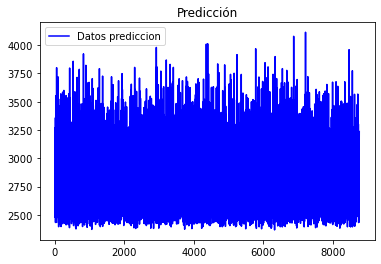

In [22]:
# plt.plot(y_test, color='red', label='Datos reales')
plt.plot(y_pred, color='blue', label= 'Datos prediccion')
plt.title('Predicción')
plt.legend()
plt.show()

In [13]:
y_test

8268     2000.0
18492    2400.0
35305    2100.0
15189    4400.0
13225    4000.0
          ...  
18747    2000.0
4697     3600.0
31882    4100.0
37915    2400.0
2998     3200.0
Name: KW-H, Length: 8765, dtype: float64